### 필수과제
- prophet에 대한 파라미터를 모두 다 정리해 주시고
- 실제 파라미터를 넣어서 예측값을 고도화 시켜주세요
- 모두 예측값을 만들어서 실제값과 비교해서 오차율을 계산해 주세요. (오차율계산법 확인)
- 기본으로만 사용했던 prophet 예측값과, 실제 파라미터를 튜닝햇을때 예측값을 비교하고
- 어떤 파라미터가 실제값에 영향을 주었는지 정리하고 발표해 주세요!

In [2]:
# import necessary libraries
import numpy as np 
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings
warnings.filterwarnings('ignore')  
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
import datetime as dt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd
#from plotnine import *
import io
# to predictive Ab
import statistics as st
%matplotlib inline
import matplotlib.dates as mdates
from pandas import DataFrame
from pandas import to_datetime
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from  sklearn.metrics import mean_absolute_error

In [4]:
df = pd.read_csv('../dataset/sales_data.csv', encoding='unicode_escape') # 유니코드 오류로 인해 encoding = 'unicode_escape' 사용

In [5]:
pd.to_datetime(df['InvoiceDate']) # 컬럼들 중 InvoiceDate 컬럼을 시계열 데이터로 변환
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']) # InvoiceDate 컬럼의 값을 시계열 데이터로 덮어쓰기
df_1=df.copy() # 원본을 유지하기 위해, .copy를 통한 df 데이터프레임의 복사본 생성
df_1 =df_1[df_1.Quantity >0] # 수량이 -마이너스 제거 
df_1 = df_1[df_1.UnitPrice >0] # 가격이 양수인 것들만 추출
df_1['Q_price'] = df_1['Quantity'] * df_1['UnitPrice'] # 수량과 개당 가격을 곱한 값을 Q_price라는 파생변수에 생성 
df_1 #총 주문 예측

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Q_price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


In [6]:
df_1= df_1[['InvoiceDate','Q_price']] # 두 가지 변수로만 가지고 시계열을 예측한다!
# 프로펫은 시계열 데이터와 타겟 값으로만 예측 가능
##프로펫은 컬럼의 이름을 바꿔줘야 한다!
# 필수과정 
# 시계열값은 ds, 예측값(내가 예측하고 싶은 값, y) y

df_1.rename(columns={'InvoiceDate':'ds','Q_price':'y'},inplace=True)
df_1

,ds,y
0,2010-12-01 08:26:00,15.30
1,2010-12-01 08:26:00,20.34
2,2010-12-01 08:26:00,22.00
3,2010-12-01 08:26:00,20.34
4,2010-12-01 08:26:00,20.34
...,...,...
541904,2011-12-09 12:50:00,10.20
541905,2011-12-09 12:50:00,12.60
541906,2011-12-09 12:50:00,16.60
541907,2011-12-09 12:50:00,16.60


<AxesSubplot:>

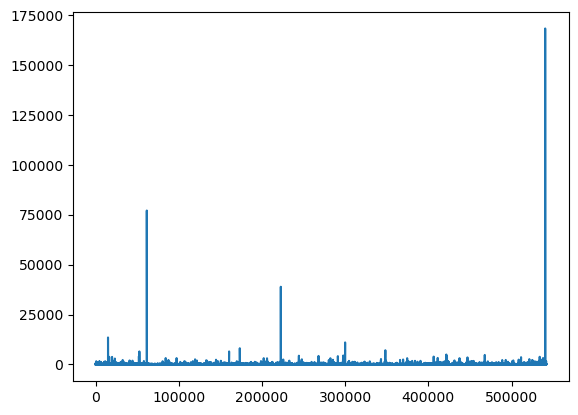

In [7]:
df_1.y.plot()
## 축을 조정해서 트렌드가 어떤 경향을 보이는지 꼭 체크하기
## 시계열데이터는 결국 과거에 대한 패턴을 학습하여 미래를 예측 
## 과거 데이터로 지금까지 트렌드가 우상향하는 증가인지, 감소하는지 
## 실제값이 나왔을 때 트렌드와 함께 비교해서 맞는지?

In [8]:
df_1 = df_1.set_index('ds')  # 시계열데이터 컬럼을 인덱스로 지정하여 resample 사용 가능하게 만들기
df_2 = df_1.resample('D').sum() # 시계열 데이터를 resample을 통해 일별 합계을 구한다.
df_2 #인덱스를 풀어야 합니다! 꼭

,y
ds,
2010-12-01,58960.79
2010-12-02,47748.38
2010-12-03,46943.71
2010-12-04,0.00
2010-12-05,31774.95
...,...
2011-12-05,88741.96
2011-12-06,56713.21
2011-12-07,75439.16


In [10]:
df_2.reset_index(inplace=True)
# train, test 나눠야 한다.
# train set은 270개, test set은 104로 구성되어있음.
train = df_2[:270]
test = df_2[270:]
# 프로펫으로 시계열 분석을 진행해보자!
# daily_seasonality, growth 파라미터를 설정 후 train set을 이용하여 모델 학습
prophet = Prophet(daily_seasonality = True,
                 growth='linear')

prophet.fit(train)

19:23:38 - cmdstanpy - INFO - Chain [1] start processing
19:23:38 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
future =prophet.make_future_dataframe(periods=30) #뒤에 얼마나 예측할 것인가?
forecast = prophet.predict(future)
# 이후 30일을 예측하고 예측값을 forecast에 저장
forecast[['ds','yhat']][270:300] #실제 프로펫이 예측한 값
df_2[270:300] # 실제 값.

,index,ds,y
270,270,2011-08-28,10805.030
271,271,2011-08-29,0.000
272,272,2011-08-30,31866.310
273,273,2011-08-31,25380.170
274,274,2011-09-01,37370.150
275,275,2011-09-02,42322.020
276,276,2011-09-03,0.000
277,277,2011-09-04,17119.590
278,278,2011-09-05,37157.140
279,279,2011-09-06,28349.910


In [ ]:
#prophet 파라미터 정리
#changepoint_prior_scale : 추세에 따라 데이터를 유연하게 반영할 건지 결정하는 파라미터
#                        : 추세에 유연하게 반응 할려면 0.05보다 크게 설정
#                        : 추가적으로 기준일의 전날까지 반영할 것이면 lower_window=-1, upper_window=0

#changepoint_range  : change point의 설정 가능 범위
#                   : 0.9일 경우 데이터의 90%fmf changepoint로 지정할 수 있다.

#n_changepoints  :자동적으로 배치된 변경점의 수

#seasonality_prior_scale : 계절의 유연성을 조절. 값이 커지면 계절성의 영향이 커짐

#seasonality_mode : 'addtive' : 시계열의 진폭이 일정할 때 사용
#                 : 'multiplicative' : 시계열 데이터의 진폭이 점점 증가하거나 감소할 때 사용

#yearly_seasonality : 연간 계절성을 가질시 True, False로 설정
#weekly_seasonality : 주간 계절성
#daily_seasonality : 일간 계절성

#mcmc_samples : 계절의 불확실성을 확인할 때 사용
#             : 불확실성을 얻기 위해 전체 베이지안 샘플링을 수행해야 한다.

#holidays_prior_scale : 휴일의 영향에 따라 유연성을 조절

#holidays: 지정된 공휴일의 데이터프레임을 전달
#        : 휴일 효과는 holidays_prior_scale을 통해서 조절 할 수 있다.

#growth : 'linear', 'logistic'
#       : logistic을 사용할 때에는 cap, floor을 설정.

#interval_width : yhat_upper, yhjat_lower 같은 불확실성 반환
#               : 불확실성 구간에만 영향을 미치기 때문에 조정할 필요없음

#uncertainty_samples: 불확실성 구간 조절.


In [13]:
actual_value = df_2[270:300]
actual_value = actual_value.set_index('index')
actual_value

,ds,y
index,,
270,2011-08-28,10805.030
271,2011-08-29,0.000
272,2011-08-30,31866.310
273,2011-08-31,25380.170
274,2011-09-01,37370.150
275,2011-09-02,42322.020
276,2011-09-03,0.000
277,2011-09-04,17119.590
278,2011-09-05,37157.140


In [14]:
#changepoint_prior_scale 기본값 0.05보다 크게 한 0.07로 파라미터를 적용해 보았다.
prophet=Prophet(changepoint_prior_scale=0.07, #추세에 따라 데이터를 유연하게 반영할 것인가? 0.05이상일 시 유연하게 반영
               seasonality_mode='additive', #addtive=시계열의 진폭이 일정, multiflicative=시계열의 데이터 진폭이 일정x
               changepoint_range=0.8, #change point의 설정 가능 범위 0.8이면 이 데이터의 80%를 changepoint로 설정
               growth='linear') #logistic을 사용할 때에는 cap, floor 설정
prophet.fit(train)

19:28:16 - cmdstanpy - INFO - Chain [1] start processing
19:28:16 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
future =prophet.make_future_dataframe(periods=30)
forecast = prophet.predict(future)

In [16]:
a1=forecast[['ds','yhat']][270:]
a1

,ds,yhat
270,2011-08-28,14118.745850
271,2011-08-29,27640.266879
272,2011-08-30,38809.407654
273,2011-08-31,30194.846613
274,2011-09-01,36929.377056
275,2011-09-02,27427.216590
276,2011-09-03,2276.310757
277,2011-09-04,14289.199377
278,2011-09-05,27810.720406
279,2011-09-06,38979.861181


In [17]:
#오차율계산
#actual_value: 실제값, a:파라미터를 넣은 예측값
#사용한 오차율 공식: |예측값-실제값|/실제값*100%
(abs(a1['yhat']-actual_value['y']))/actual_value['y']*100

270    30.668271
271          inf
272    21.788207
273    18.970230
274     1.179479
275    35.193980
276          inf
277    16.533051
278    25.153765
279    37.495538
280    11.763483
281    36.417500
282     8.239065
283          inf
284    59.281969
285     5.908725
286    28.968777
287    29.427286
288    52.351337
289     0.158358
290          inf
291     7.085245
292    42.862399
293    64.127324
294    36.767345
295    36.920445
296    31.188737
297          inf
298    52.823384
299     3.453500
dtype: float64

In [18]:
#mean_absolute_error를 이용한 오차율 구하기
#- 실제 값과 예측 값의 차이(Error)를 절대값으로 변환해 평균화

#- MAE는 에러에 절대값을 취하기 때문에 에러의 크기 그대로 반영된다. 그러므로 예측 결과물의 에러가 10이 나온 것이 5로 나온 것보다 2배가 나쁜 도메인에서 쓰기 적합한 산식이다.

#- 에러에 따른 손실이 선형적으로 올라갈 때 적합하다.

#- 이상치가 많을 때
#df_2 : 실제데이터 forecast : 파라미터를 적용시킨 결과
mae = mean_absolute_error(df_2.y[270:300], forecast['yhat'][270:])
mae

11888.851595113227

In [19]:
#changepoint_prior_scale의 값을 그대로 두고 seasonality_mode를 바꾸어보았다.
#multiplicative를 사용해 시계열의 데이터 진폭이 일정하지 않다는 가정의 파라미터를 사용하였다.
prophet=Prophet(changepoint_prior_scale=0.07, #추세에 따라 데이터를 유연하게 반영할 것인가?
               seasonality_mode='multiplicative' , #addtive=시계열의 진폭이 일정, multiflicative=시계열의 데이터 진폭이 일정x
               changepoint_range=0.8, #change point의 설정 가능 범위 0.8이면 이 데이터의 80%를 changepoint로 설정
               growth='linear') #logistic을 사용할 때에는 cap, floor 설정
prophet.fit(train)

19:30:31 - cmdstanpy - INFO - Chain [1] start processing
19:30:31 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
future =prophet.make_future_dataframe(periods=30)
forecast = prophet.predict(future)
a2=forecast[['ds','yhat']][270:]
a2

,ds,yhat
270,2011-08-28,13207.028051
271,2011-08-29,27733.997050
272,2011-08-30,40030.916797
273,2011-08-31,30755.754469
274,2011-09-01,38085.937643
275,2011-09-02,27652.310727
276,2011-09-03,79.918430
277,2011-09-04,13300.013521
278,2011-09-05,27929.064972
279,2011-09-06,40312.192861


In [21]:
#오차율계산
#re: 실제값, a:파라미터를 넣은 예측값
#사용한 오차율 공식: |예측값-실제값|/실제값*100%
(abs(a2['yhat']-actual_value['y']))/actual_value['y']*100
#시계열 데이터의 진폭에 관련된 파라미터여서 그렇게 대체로 숫자에 큰 변화는 없으나 270,277번의 오차율이 크게 차이가 나는 부분도 보였다.

270    22.230369
271          inf
272    25.621438
273    21.180254
274     1.915399
275    34.662120
276          inf
277    22.311145
278    24.835267
279    42.195135
280    10.001554
281    41.025494
282     7.413295
283          inf
284    62.285640
285     5.428002
286    26.350433
287    32.189871
288    50.625667
289     1.138068
290          inf
291    14.351482
292    42.522286
293    62.709618
294    35.331594
295    34.483538
296    30.462467
297          inf
298    56.717188
299     2.798355
dtype: float64

In [22]:
#mean_absolute_error를 이용한 오차율 구하기
mae = mean_absolute_error(df_2.y[270:300], forecast['yhat'][270:])
mae
#위의 오차율과 비교했을 때 오차율이 줄어든 것을 보았을 때 multiplicative 파라미터를 사용하는 것이 더 좋다.

11584.80724408804

In [23]:
#changepoint_prior_scale, seasonality_mode  값을 그대로 두고 daily_seasonality=True 파라미터를 설정했다.
prophet=Prophet(changepoint_prior_scale=0.07, #추세에 따라 데이터를 유연하게 반영할 것인가?
               seasonality_mode='multiplicative' , #addtive=시계열의 진폭이 일정, multiflicative=시계열의 데이터 진폭이 일정x
               changepoint_range=0.8, #change point의 설정 가능 범위 0.8이면 이 데이터의 80%를 changepoint로 설정
               growth='linear',
               daily_seasonality=True) #일계절성
prophet.fit(train)

19:31:24 - cmdstanpy - INFO - Chain [1] start processing
19:31:24 - cmdstanpy - INFO - Chain [1] done processing


In [24]:
future =prophet.make_future_dataframe(periods=30)
forecast = prophet.predict(future)
a3=forecast[['ds','yhat']][270:]
a3

,ds,yhat
270,2011-08-28,13507.248340
271,2011-08-29,28122.287115
272,2011-08-30,40590.739876
273,2011-08-31,31231.545291
274,2011-09-01,38653.524229
275,2011-09-02,28091.166503
276,2011-09-03,279.395649
277,2011-09-04,13614.673813
278,2011-09-05,28345.694680
279,2011-09-06,40912.833118


In [25]:
#오차율계산
#re: 실제값, a:파라미터를 넣은 예측값
#사용한 오차율 공식: |예측값-실제값|/실제값*100%
(abs(a3['yhat']-actual_value['y']))/actual_value['y']*100
#전반적인 오차율이 크지는 않지만 줄었다. daily_seasonality=True로 두는것이 분석에 도움이 된다.

270    25.008893
271          inf
272    27.378224
273    23.054910
274     3.434223
275    33.625175
276          inf
277    20.473132
278    23.714003
279    44.313802
280     8.526991
281    43.255766
282     5.859569
283          inf
284    61.358902
285     3.931720
286    25.186623
287    34.474905
288    49.800427
289     2.926143
290          inf
291    12.169682
292    41.561640
293    62.087173
294    34.156228
295    33.330391
296    29.171471
297          inf
298    55.576130
299     1.088296
dtype: float64

In [26]:
#mean_absolute_error를 이용한 오차율 구하기
mae = mean_absolute_error(df_2.y[270:300], forecast['yhat'][270:])
mae
#파라미터를 추가했더니 오차율이 줄었다.

11484.723292948092

In [27]:
#changepoint_prior_scale, seasonality_mode  값을 그대로 두고 daily_seasonality=True 파라미터를 설정했다.
prophet=Prophet(changepoint_prior_scale=0.08, #추세에 따라 데이터를 유연하게 반영할 것인가?
               seasonality_mode='multiplicative' , #addtive=시계열의 진폭이 일정, multiflicative=시계열의 데이터 진폭이 일정x
               changepoint_range=0.8, #change point의 설정 가능 범위 0.8이면 이 데이터의 80%를 changepoint로 설정
               growth='linear',
               daily_seasonality=True) #일계절성
prophet.fit(train)

19:32:32 - cmdstanpy - INFO - Chain [1] start processing
19:32:33 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
future =prophet.make_future_dataframe(periods=30)
forecast = prophet.predict(future)
a4=forecast[['ds','yhat']][270:]
a4

,ds,yhat
270,2011-08-28,13659.424361
271,2011-08-29,28087.972992
272,2011-08-30,40217.786793
273,2011-08-31,30576.597935
274,2011-09-01,37649.142710
275,2011-09-02,27720.774828
276,2011-09-03,650.511692
277,2011-09-04,13738.971666
278,2011-09-05,28251.410718
279,2011-09-06,40451.610865


In [29]:
#오차율계산
#re: 실제값, a:파라미터를 넣은 예측값
#사용한 오차율 공식: |예측값-실제값|/실제값*100%
(abs(a4['yhat']-actual_value['y']))/actual_value['y']*100

#mean_absolute_error를 이용한 오차율 구하기
mae = mean_absolute_error(df_2.y[270:300], forecast['yhat'][270:])
mae
#파라미터를 추가했더니 오차율이 줄었다.

11608.8969899854

In [38]:
#changepoint_prior_scale, seasonality_mode  값을 그대로 두고 daily_seasonality=True 파라미터를 설정했다.
prophet=Prophet(changepoint_prior_scale=0.07, #추세에 따라 데이터를 유연하게 반영할 것인가?
               seasonality_mode='multiplicative' , #addtive=시계열의 진폭이 일정, multiflicative=시계열의 데이터 진폭이 일정x
               changepoint_range=0.8, #change point의 설정 가능 범위 0.8이면 이 데이터의 80%를 changepoint로 설정
               growth='linear',
               daily_seasonality=True) #일계절성
prophet.fit(train)
future =prophet.make_future_dataframe(periods=30)
forecast = prophet.predict(future)
a5=forecast[['ds','yhat']][270:]
a5
#오차율계산
#re: 실제값, a:파라미터를 넣은 예측값
#사용한 오차율 공식: |예측값-실제값|/실제값*100%
(abs(a5['yhat']-actual_value['y']))/actual_value['y']*100

#mean_absolute_error를 이용한 오차율 구하기
mae = mean_absolute_error(df_2.y[270:300], forecast['yhat'][270:])
mae
#파라미터를 추가했더니 오차율이 줄었다.

19:34:53 - cmdstanpy - INFO - Chain [1] start processing
19:34:53 - cmdstanpy - INFO - Chain [1] done processing


11484.723292948092

In [44]:
df_1.resample('D').sum()
df_1

,y
ds,
2010-12-01 08:26:00,15.30
2010-12-01 08:26:00,20.34
2010-12-01 08:26:00,22.00
2010-12-01 08:26:00,20.34
2010-12-01 08:26:00,20.34
...,...
2011-12-09 12:50:00,10.20
2011-12-09 12:50:00,12.60
2011-12-09 12:50:00,16.60


In [55]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   index   374 non-null    int64         
 1   ds      374 non-null    datetime64[ns]
 2   y       374 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 8.9 KB


<AxesSubplot:>

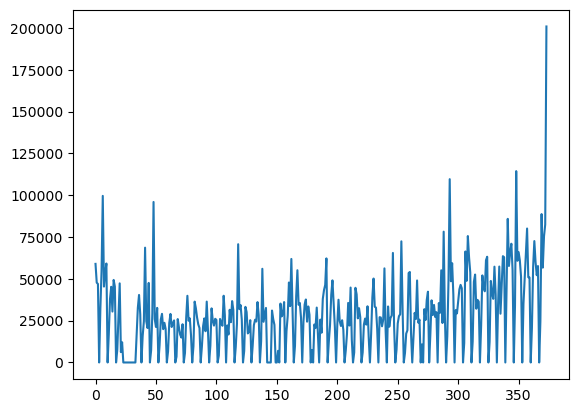

In [56]:
df_2.y.plot()

In [59]:
df_2.loc[df_2.y>70000, ['ds','y']]

,ds,y
6,2010-12-07,99618.20
48,2011-01-18,95978.05
118,2011-03-29,70711.92
253,2011-08-11,72433.79
288,2011-09-15,78218.95
293,2011-09-20,109612.03
308,2011-10-05,75593.63
341,2011-11-07,85881.81
344,2011-11-10,71008.26
348,2011-11-14,114419.89


In [61]:
#2011년의 추수감사절은 11월 24일, 추수감사절 전 날 y 값이 크다.
test

,index,ds,y
270,270,2011-08-28,10805.03
271,271,2011-08-29,0.00
272,272,2011-08-30,31866.31
273,273,2011-08-31,25380.17
274,274,2011-09-01,37370.15
...,...,...,...
369,369,2011-12-05,88741.96
370,370,2011-12-06,56713.21
371,371,2011-12-07,75439.16
372,372,2011-12-08,82495.00


In [64]:
#11484.723292948092

#changepoint_prior_scale, seasonality_mode  값을 그대로 두고 daily_seasonality=True 파라미터를 설정했다.
prophet=Prophet(changepoint_prior_scale=0.07, #추세에 따라 데이터를 유연하게 반영할 것인가?
               seasonality_mode='multiplicative', #addtive=시계열의 진폭이 일정, multiflicative=시계열의 데이터 진폭이 일정x
               changepoint_range=0.8, #change point의 설정 가능 범위 0.8이면 이 데이터의 80%를 changepoint로 설정
               growth='linear',
               daily_seasonality=True) #일계절성
prophet.fit(train)
future =prophet.make_future_dataframe(periods=30)
forecast = prophet.predict(future)
a5=forecast[['ds','yhat']][270:]
a5
#오차율계산
#re: 실제값, a:파라미터를 넣은 예측값
#사용한 오차율 공식: |예측값-실제값|/실제값*100%
(abs(a5['yhat']-actual_value['y']))/actual_value['y']*100

#mean_absolute_error를 이용한 오차율 구하기
mae = mean_absolute_error(df_2.y[270:300], forecast['yhat'][270:])
mae
#파라미터를 추가했더니 오차율이 줄었다.

19:46:01 - cmdstanpy - INFO - Chain [1] start processing
19:46:01 - cmdstanpy - INFO - Chain [1] done processing


11484.723292948092

In [66]:
m=Prophet()

In [72]:
m.fit(train)

19:53:01 - cmdstanpy - INFO - Chain [1] start processing
19:53:01 - cmdstanpy - INFO - Chain [1] done processing


<function matplotlib.pyplot.show(close=None, block=None)>

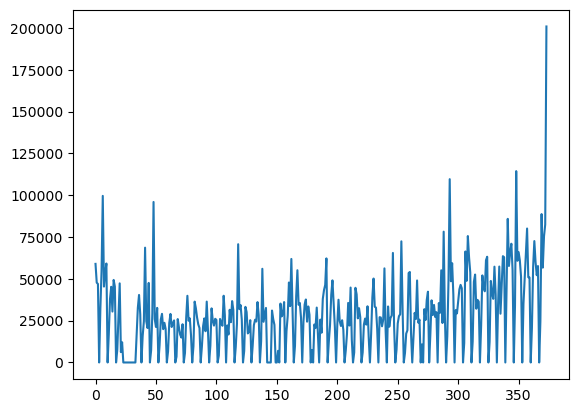

In [68]:

plt.plot(df_2.y)
plt.show

<AxesSubplot:>

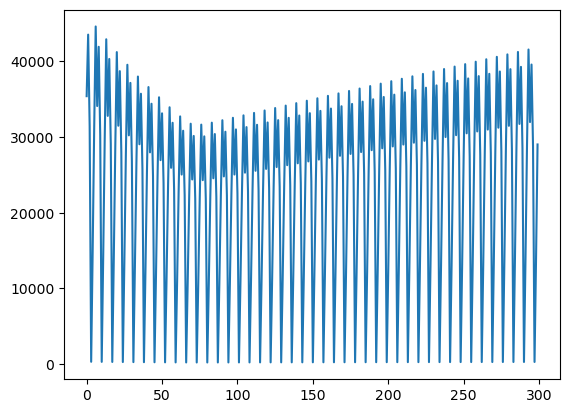

In [71]:
forecast.yhat.plot()

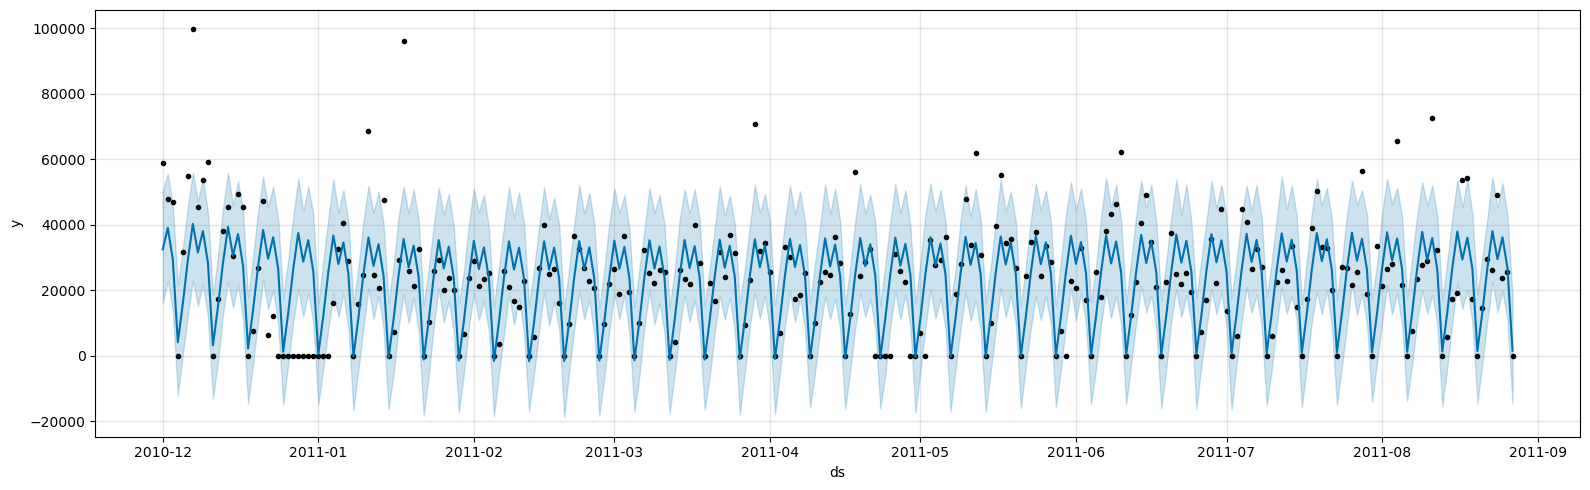

In [73]:
forecast = m.predict(train)
fig, ax = plt.subplots(figsize=(16,5))
m.plot(forecast, ax=ax)
plt.show()

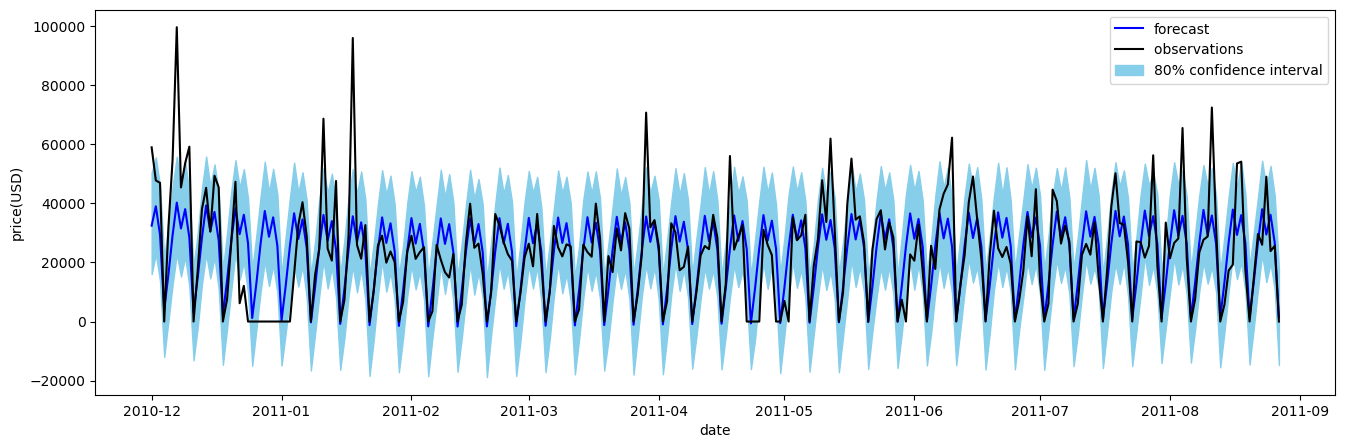

In [76]:
fig, ax = plt.subplots(figsize=(16,5))

plt.plot(forecast['ds'].dt.to_pydatetime(),forecast['yhat'], label='forecast', color='blue')
plt.plot(train['ds'].dt.to_pydatetime(),train['y'], label='observations ', color='black')
plt.fill_between(forecast['ds'].dt.to_pydatetime(), forecast['yhat_upper'],forecast['yhat_lower'],color='skyblue',label='80% confidence interval')
plt.legend()
plt.xlabel('date')
plt.ylabel('price(USD)')
plt.show()

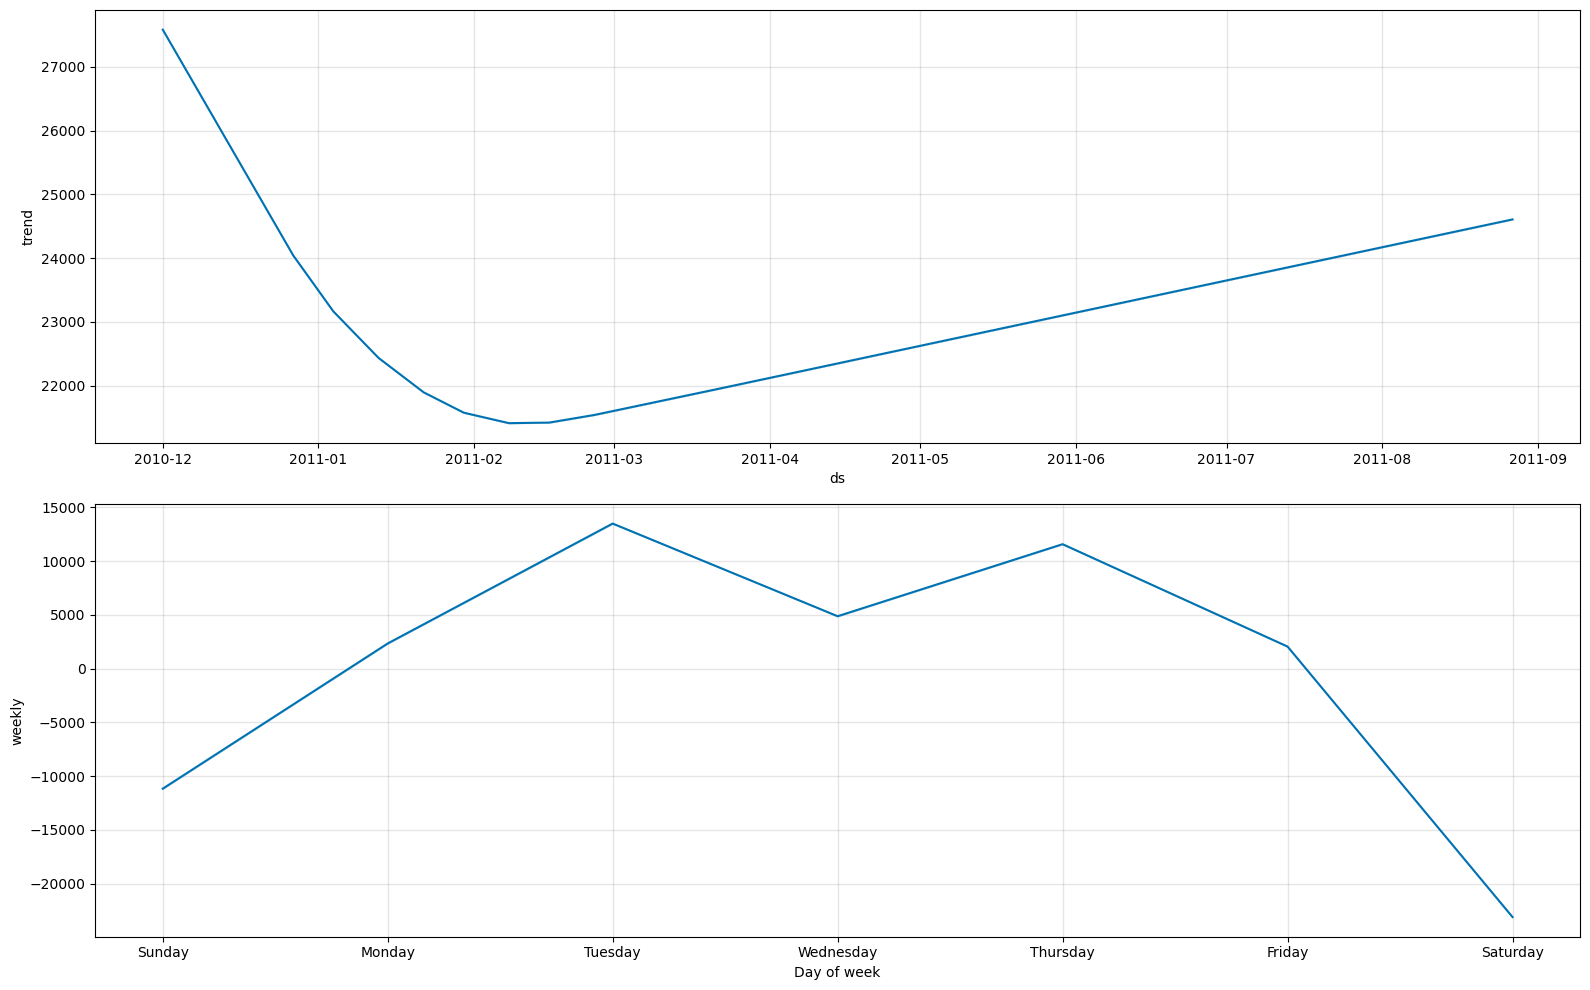

In [77]:
m.plot_components(forecast,figsize=(16,10))
plt.show()
